# FRAUD DETECTION MODEL FOR MOBILE MONEY TRANSACTIONS

 ### Import Relevant Pakages

In [117]:
#pip install mlxtend
#pip install xgboost

In [135]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV




%matplotlib inline

sns.set()

### Import dataset

In [7]:
sData = pd.read_csv('datasets.csv',nrows = 1000)
sData.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,timeStamp,profileOrig,locationOrig,subscriberBehaviourOrig,simSwapOrig,networkDest,profileDest,locationDest,thresholdOrig
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,"(datetime.datetime(2009, 2, 3, 8, 10, 41), 303...",Organization,Upper West Region,Balance Check,No,VODAFONE,Personal,Upper West Region,2000000
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,"(datetime.datetime(2009, 2, 3, 9, 10, 41), 272...",Organization,Central Region,Balance Check,Yes,AIRTELTIGO,Personal,Central Region,2000000
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,"(datetime.datetime(2009, 2, 3, 10, 10, 41), 15...",Personal,North East Region,Balance Check,No,MTN,Personal,Ahafo Region,900000
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,"(datetime.datetime(2009, 2, 3, 11, 10, 41), 93...",Personal,Greater Accra Region,PIN Reset,No,VODAFONE,Organization,Bono Region,900000
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,"(datetime.datetime(2009, 2, 3, 12, 10, 41), 18...",Organization,Western North Region,PIN Reset,No,MTN,Organization,Central Region,2000000


In [8]:
sData = sData.drop(['step'], axis = 1) 

In [9]:
nRow, nCol = sData.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 19 columns


## Metadata

#### Getting to know the meaning of the columns

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### Exploratory Data Analysis

In [10]:
sData.describe(include = 'object').transpose()

,count,unique,top,freq
type,1000,5,PAYMENT,437
nameOrig,1000,1000,C767511741,1
nameDest,1000,597,C1590550415,23
timeStamp,1000,1000,"(datetime.datetime(2009, 2, 26, 18, 10, 41), 7...",1
profileOrig,1000,2,Personal,518
locationOrig,1000,14,Western North Region,90
subscriberBehaviourOrig,1000,2,Balance Check,510
simSwapOrig,1000,2,No,928
networkDest,1000,3,MTN,353
profileDest,1000,2,Organization,510


#### Rename the columns

In [11]:
sData.rename(columns={
     'oldbalanceDest':'oldBalanceDest', 
     'newbalanceDest':'newBalanceDest',
     'oldbalanceOrg':'oldBalanceOrig', 
     'newbalanceOrig':'newBalanceOrig' 
}, inplace=True)

#### Checking for the percentage of null values in dataset

In [12]:
#No null values or missing values in data
sData.isna().mean() * 100

type                       0.0
amount                     0.0
nameOrig                   0.0
oldBalanceOrig             0.0
newBalanceOrig             0.0
nameDest                   0.0
oldBalanceDest             0.0
newBalanceDest             0.0
isFraud                    0.0
isFlaggedFraud             0.0
timeStamp                  0.0
profileOrig                0.0
locationOrig               0.0
subscriberBehaviourOrig    0.0
simSwapOrig                0.0
networkDest                0.0
profileDest                0.0
locationDest               0.0
thresholdOrig              0.0
dtype: float64

In [13]:
sData.type.value_counts()

PAYMENT     437
CASH_OUT    230
CASH_IN     183
TRANSFER     99
DEBIT        51
Name: type, dtype: int64

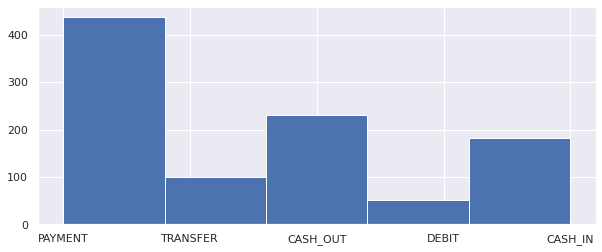

In [14]:
sData['type'].hist(bins =5, figsize = (10,4))

#### Checking the total number of fradulent transactions in the dataset

In [15]:
sData.isFraud.value_counts()

0    991
1      9
Name: isFraud, dtype: int64

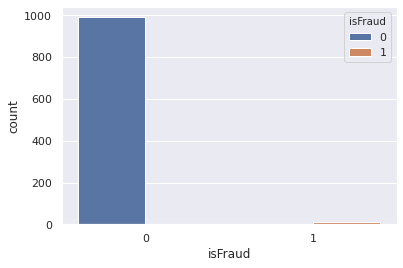

In [16]:
sns.countplot(x = 'isFraud', hue= 'isFraud', data=sData)

#### Checking fradulent transaction for each type of payments

In [17]:
count_payment = sData.loc[(sData.isFraud == 1) & (sData.type == 'PAYMENT')]

count_transfer = sData.loc[(sData.isFraud == 1) & (sData.type == 'TRANSFER')]

count_cashout = sData.loc[(sData.isFraud == 1) & (sData.type == 'CASH_OUT')]

count_debit = sData.loc[(sData.isFraud == 1) & (sData.type == 'DEBIT')]

count_cashin = sData.loc[(sData.isFraud == 1) & (sData.type == 'CASH_IN')]

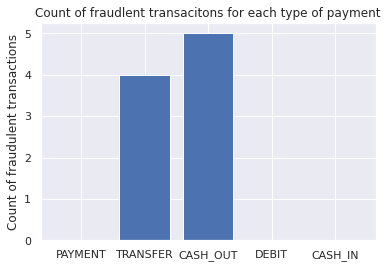

In [18]:
#Visualisation of all types of payments for number of frauds

labels = ['PAYMENT','TRANSFER','CASH_OUT','DEBIT','CASH_IN']
plt.bar([1,2,3,4,5],[len(count_payment),len(count_transfer), len(count_cashout), len(count_debit), len(count_cashin)])
plt.ylabel('Count of fraudulent transactions')
plt.title('Count of fraudlent transacitons for each type of payment')
plt.xticks([1,2,3,4,5], labels)
plt.show()

In [19]:
#Minimum fraud amoount for both cash out and transfer

#### Checking customer transactions for repeated fradulent cases 

In [20]:
count_fraud = sData.loc[(sData['isFraud'] == 1) ]

In [21]:
count_nameOrig = count_fraud['nameOrig'].value_counts()
count_nameOrig.sort_values(ascending = False)
count_nameOrig.head()

C840083671     1
C749981943     1
C2101527076    1
C1305486145    1
C467632528     1
Name: nameOrig, dtype: int64

#### Checking despostied transactions for repeated fradulent cases

In [22]:
count_nameDest = count_fraud['nameDest'].value_counts()
count_nameDest.sort_values()
count_nameDest.head()

C972765878     1
C38997010      1
C431687661     1
C1007251739    1
C667346055     1
Name: nameDest, dtype: int64

#### Check the amount in account before and after CASH_OUT & TRANSER

In [23]:
transferBal = sData.loc[(sData.isFraud == 1) & (sData.type == 'TRANSFER') & 
                            (sData.amount == sData.oldBalanceOrig)]

cashOutBal = sData.loc[(sData.isFraud == 1) & (sData.type == 'CASH_OUT') & 
                            (sData.amount == sData.oldBalanceOrig)]

transferBal = transferBal.isFraud.count() / count_transfer.isFraud.count() * 100

cashOutBal = cashOutBal.isFraud.count() / count_cashout.isFraud.count() * 100

bal = (cashOutBal + transferBal) / 2
print(str(bal) + ' percent of the time, fraudulent cases either transer or cash_out all thier money' )


90.0 percent of the time, fraudulent cases either transer or cash_out all thier money


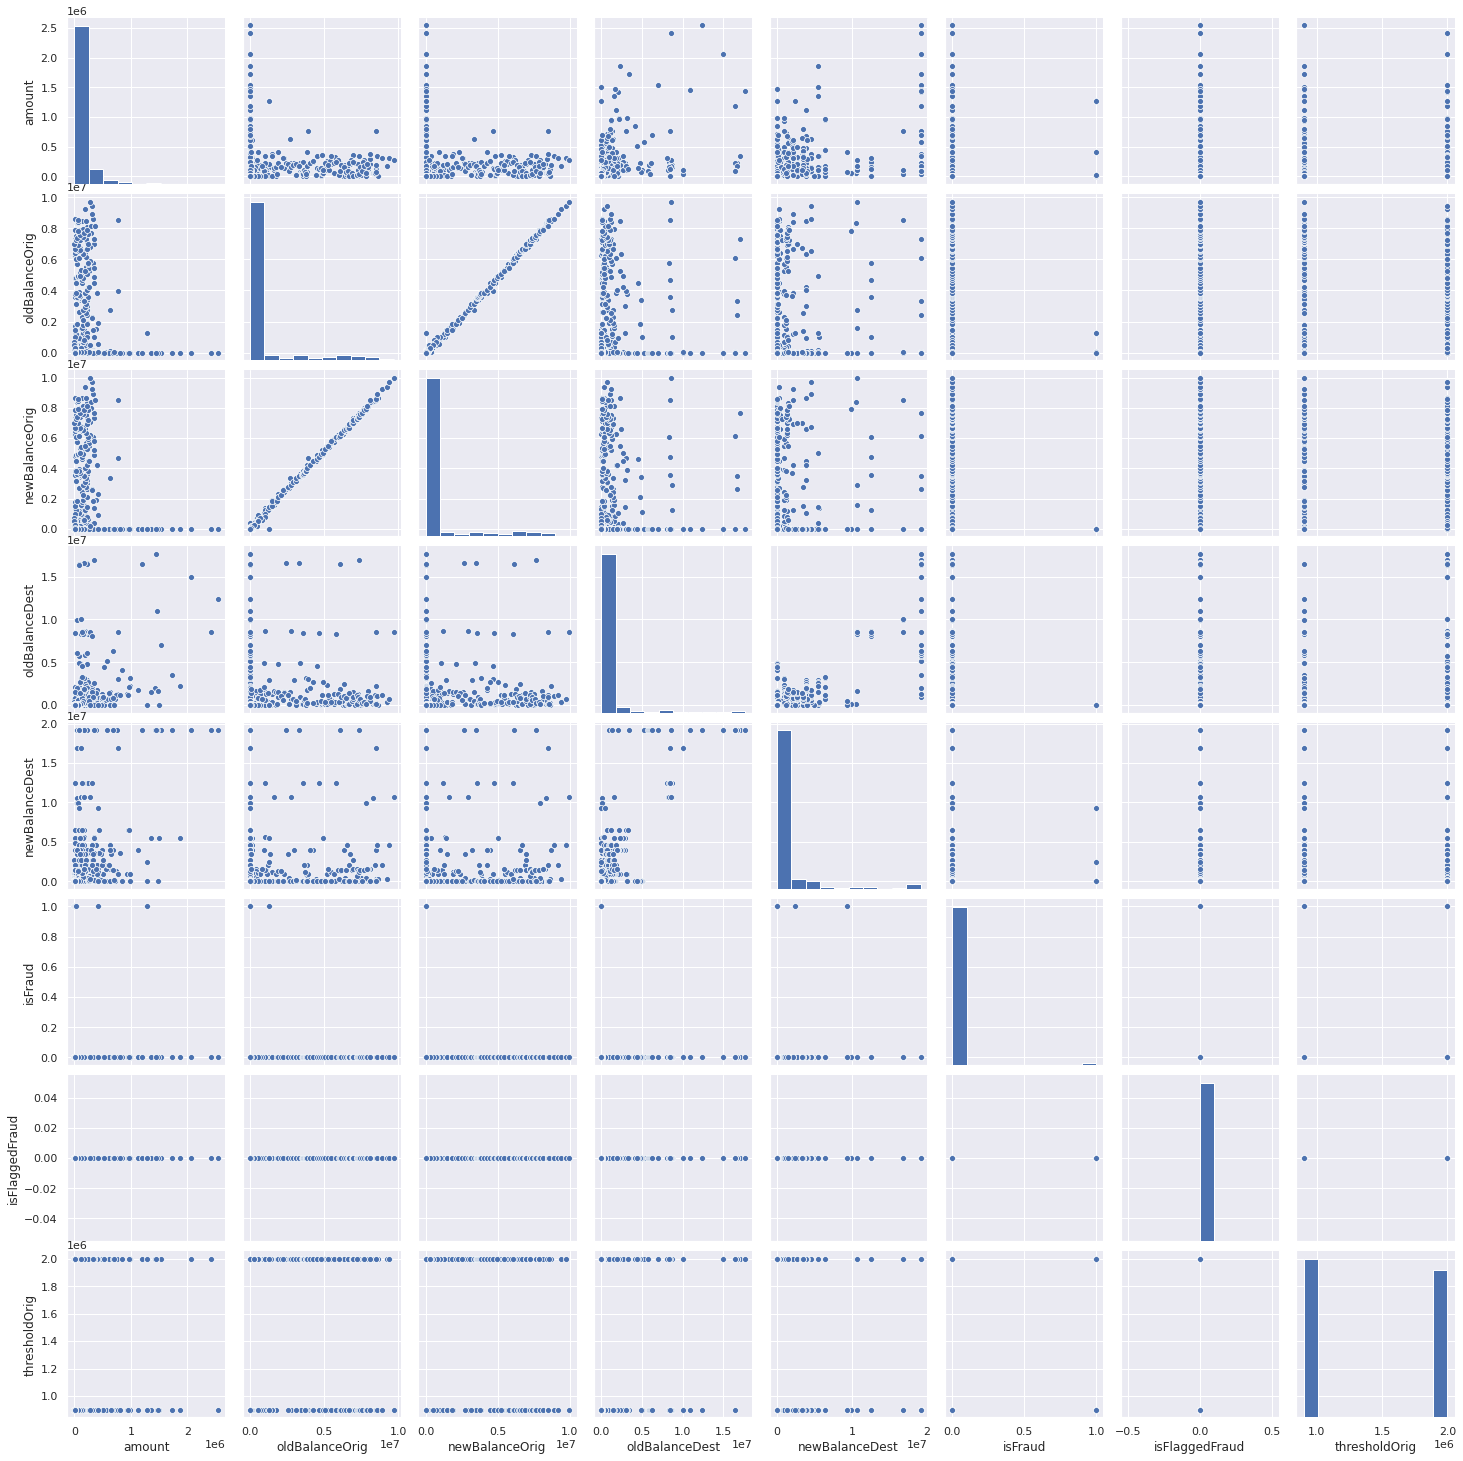

In [24]:
sns.pairplot(sData)

### From the pair plot above


In [25]:
pd.crosstab(index=sData['profileOrig'], columns=sData['isFraud'])

isFraud,0,1
profileOrig,,
Organization,479,3
Personal,512,6


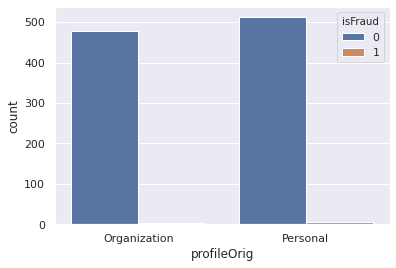

In [26]:
sns.countplot(x = 'profileOrig', hue= 'isFraud', data=sData)

In [27]:
pd.crosstab(index=sData['simSwapOrig'], columns=sData['isFraud'])

isFraud,0,1
simSwapOrig,,
No,919,9
Yes,72,0


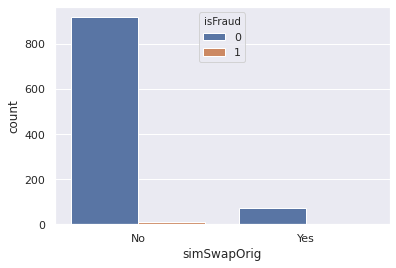

In [28]:
sns.countplot(x = 'simSwapOrig', hue= 'isFraud', data=sData)

In [29]:
pd.crosstab(index=sData['subscriberBehaviourOrig'], columns=sData['isFraud'])

isFraud,0,1
subscriberBehaviourOrig,,
Balance Check,506,4
PIN Reset,485,5


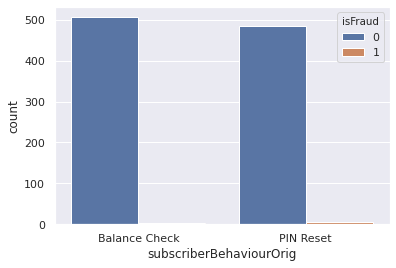

In [30]:
sns.countplot(x = 'subscriberBehaviourOrig', hue= 'isFraud', data=sData)

In [31]:
pd.crosstab(index=sData['networkDest'], columns=sData['isFraud'])

isFraud,0,1
networkDest,,
AIRTELTIGO,326,4
MTN,350,3
VODAFONE,315,2


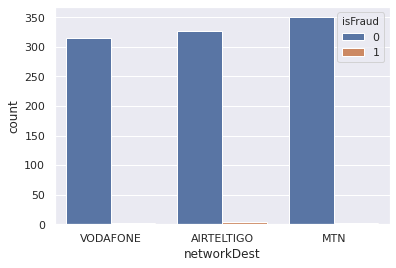

In [32]:
sns.countplot(x = 'networkDest', hue= 'isFraud', data=sData)

### Number of fraud cases according  destination locations

In [33]:
pd.crosstab(index=sData['locationDest'], columns=sData['isFraud'])

isFraud,0,1
locationDest,,
Ahafo Region,67,2
Bono East Region,77,1
Bono Region,72,1
Central Region,83,0
Eastern RegionAshanti RegionNorthern Region,75,2
Greater Accra Region,64,0
North East Region,76,1
Oti Region,72,0
Savannah Region,78,0


[Text(0, 0, 'Upper West Region'),
 Text(0, 0, 'Central Region'),
 Text(0, 0, 'Ahafo Region'),
 Text(0, 0, 'Bono Region'),
 Text(0, 0, 'Eastern RegionAshanti RegionNorthern Region'),
 Text(0, 0, 'Oti Region'),
 Text(0, 0, 'Bono East Region'),
 Text(0, 0, 'Western North Region'),
 Text(0, 0, 'Greater Accra Region'),
 Text(0, 0, 'Volta Region'),
 Text(0, 0, 'Upper East Region'),
 Text(0, 0, 'Western Region'),
 Text(0, 0, 'North East Region'),
 Text(0, 0, 'Savannah Region')]

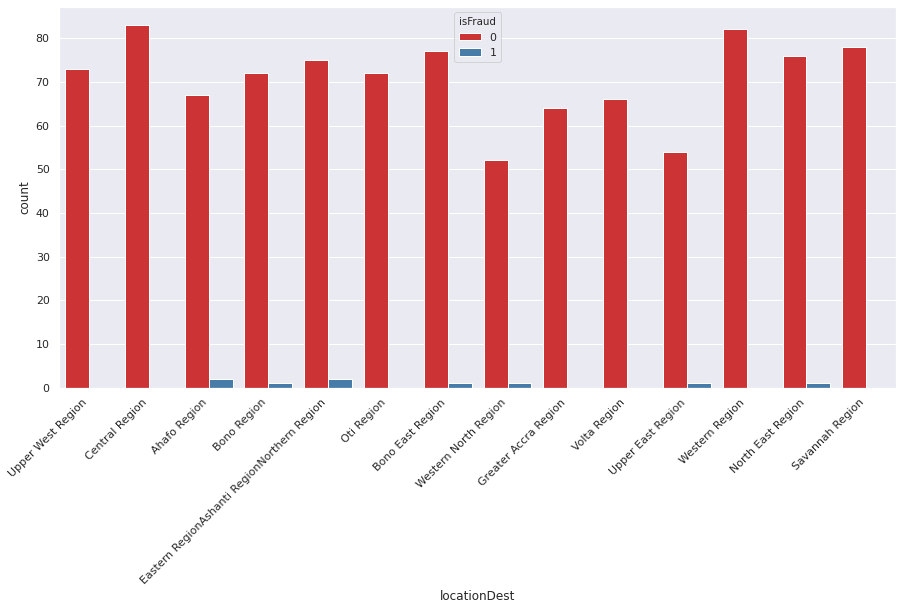

In [34]:
plt.figure(figsize=(15,7))
chart = sns.countplot(sData['locationDest'], hue=sData['isFraud'], palette='Set1' )
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

#### Working with Categorical Variables - Convert categorical variables into numerical variables

In [35]:
label = LabelEncoder()
sData['type'] = label.fit_transform(sData['type'])
sData['nameOrig'] = label.fit_transform(sData['nameOrig'])
sData['nameDest']= label.fit_transform(sData['nameDest'])
sData['profileOrig']= label.fit_transform(sData['profileOrig']) 
sData['profileDest']= label.fit_transform(sData['profileDest']) 

sData['locationOrig'] = label.fit_transform(sData['locationOrig'])
sData['locationDest'] = label.fit_transform(sData['locationDest'])
sData['subscriberBehaviourOrig']= label.fit_transform(sData['subscriberBehaviourOrig'])
sData['simSwapOrig']= label.fit_transform(sData['simSwapOrig']) 
sData['networkDest']= label.fit_transform(sData['networkDest']) 

#### Identify the correlation in the features with a heatmap

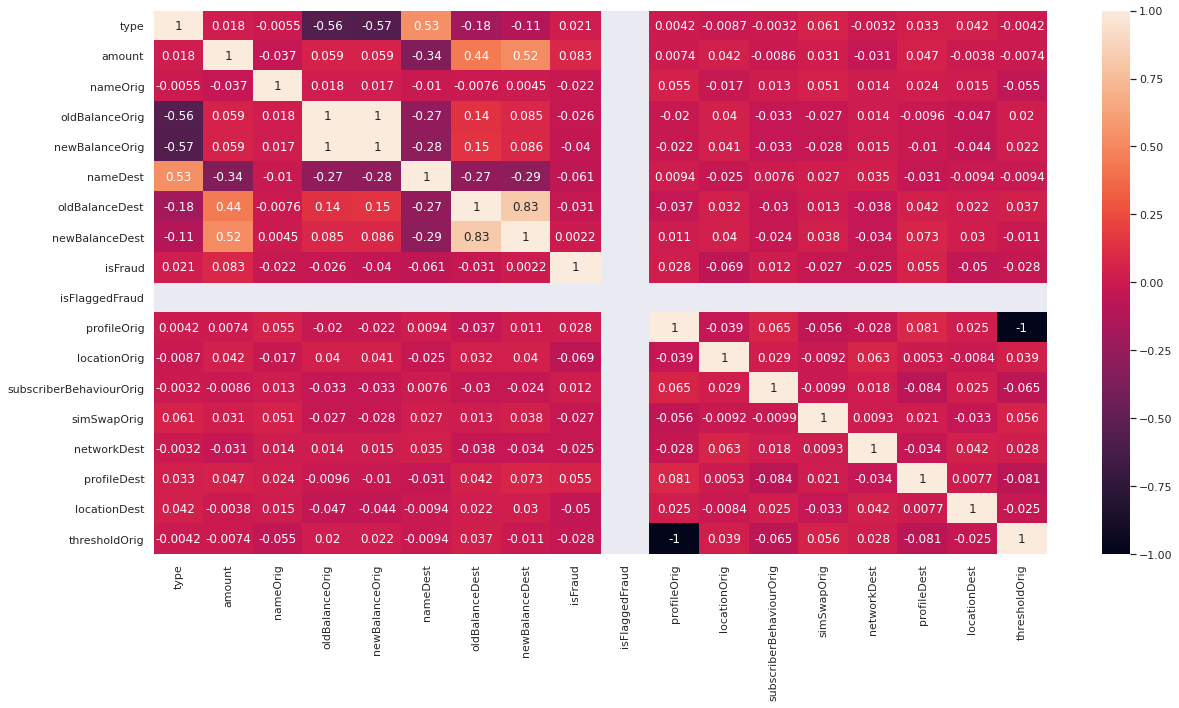

In [36]:
plt.figure(figsize = (20,10))

sns.heatmap(sData.corr(), annot = True)

    amount is fairly correlated with oldbalanceDest & newbalanceDest
    newbalanceDest & oldbalanceDest appears to be highly positively correlated
    type & oldbalanceOrg has negative correlation
    type and newbalanceOrg has a negative correlation

The model is built on synthenic data, some of the columns in the data has been mapped other have not been mapped, as a result there should be no correlations in the columns which have are not mapped. Althoug the unmapped features are not highly corralated, thier is still the need to investigate by performing a Variance inflation factor. 

### Detecting Multicollinearity using VIF

In [37]:
sData.columns

Index(['type', 'amount', 'nameOrig', 'oldBalanceOrig', 'newBalanceOrig',
       'nameDest', 'oldBalanceDest', 'newBalanceDest', 'isFraud',
       'isFlaggedFraud', 'timeStamp', 'profileOrig', 'locationOrig',
       'subscriberBehaviourOrig', 'simSwapOrig', 'networkDest', 'profileDest',
       'locationDest', 'thresholdOrig'],
      dtype='object')

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = sData[['amount', 'nameOrig', 'oldBalanceOrig', 'newBalanceOrig', 'nameDest', 'oldBalanceDest', 
                   'isFlaggedFraud','newBalanceDest', 'profileOrig','locationOrig', 'subscriberBehaviourOrig',
                   'simSwapOrig','networkDest','profileDest','thresholdOrig']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['feature'] = variables.columns

/home/selassie/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [39]:
vif

,VIF,feature
0,1.459939,amount
1,1.010239,nameOrig
2,604.596174,oldBalanceOrig
3,606.505213,newBalanceOrig
4,1.251227,nameDest
5,3.326343,oldBalanceDest
6,NaN,isFlaggedFraud
7,3.567348,newBalanceDest
8,3.256453,profileOrig
9,1.011451,locationOrig


    It is best pratise to do way with VIF values above 5 if most of the VIF values are below 5
    
    oldBalanceOrig & newBalanceOrig are highly povitivly corrrelated so one of them will have to be eliminated
    oldBalanceDest & newBalanceDest is also positive correlation so one of them will have to be eliminated   
    the VIF value for thresholdOrig is also above 5 and should be eliminated

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = sData[['amount', 'nameOrig', 'newBalanceOrig', 'nameDest', 'oldBalanceDest', 
                   'profileOrig','locationOrig', 'subscriberBehaviourOrig',
                   'simSwapOrig','networkDest','profileDest','locationDest']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['feature'] = variables.columns

In [41]:
vif

,VIF,feature
0,1.586242,amount
1,3.346415,nameOrig
2,1.238474,newBalanceOrig
3,2.527443,nameDest
4,1.415482,oldBalanceDest
5,2.024768,profileOrig
6,3.133367,locationOrig
7,1.890788,subscriberBehaviourOrig
8,1.086544,simSwapOrig
9,2.366616,networkDest


After eleminating the newbalanceOrig feature from the dataset, the VIF values appears to be in normal range, all the VIF values are below 5

## FEATURE ENGINNERING 

In [42]:
features = sData.drop(['oldBalanceOrig','timeStamp','isFraud','thresholdOrig',
                       'newBalanceDest'],axis=1)
target = sData['isFraud']



#### Feature Selection Using Univerant analysis

In [43]:
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import f_regression


select_univeriate = SelectKBest(f_regression, k=5).fit(features, target)

feature_mask = select_univeriate.get_support()

pd.DataFrame({'FeatureName': features.columns,
             'Score': select_univeriate.scores_}).sort_values(by='Score',
                                                            ascending=False)


uni_df = pd.DataFrame({'Univariate Method': features.columns[feature_mask]})

uni_df

/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/selassie/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,Univariate Method
0,amount
1,nameDest
2,locationOrig
3,profileDest
4,locationDest


#### Feature Selection Using Recrsive Feature Elimination

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

linear_regression = LinearRegression()

rfe = RFE(estimator = linear_regression,
         n_features_to_select = 5,
         step = 1)

rfe.fit(features,target)

rfe_features = features.columns[rfe.support_]

pd.DataFrame({'FeatureName' : features.columns, 
             'Rank': rfe.ranking_}).sort_values(by='Rank')

rfe_df = pd.DataFrame({'RFE Method': rfe_features})

rfe_df


,RFE Method
0,profileOrig
1,subscriberBehaviourOrig
2,simSwapOrig
3,networkDest
4,profileDest


#### Feature Selection Using Forward Selection

In [45]:
feature_selector = SequentialFeatureSelector(LinearRegression(),
                                            k_features=5,
                                            forward=True,
                                            scoring='neg_mean_squared_error',
                                            cv=4)


In [46]:
feature_filtered = feature_selector.fit(features, target)

forward_features = list(feature_filtered.k_feature_names_)
forw_df = pd.DataFrame({'Forward Method': forward_features})

forw_df

,Forward Method
0,type
1,nameDest
2,oldBalanceDest
3,locationOrig
4,simSwapOrig


In [47]:
comp_selected_col = [uni_df, rfe_df, forw_df]

final_df = pd.concat(comp_selected_col, axis=1)

final_df

,Univariate Method,RFE Method,Forward Method
0,amount,profileOrig,type
1,nameDest,subscriberBehaviourOrig,nameDest
2,locationOrig,simSwapOrig,oldBalanceDest
3,profileDest,networkDest,locationOrig
4,locationDest,profileDest,simSwapOrig


The three different featuring engineering methods choose the features as features that has the highest predictive power. As a result we will use a combination of all the features selected above in predicting which transactions are likely to be fraudulent

### Working with Imbalanced Data

using the SMOTE method to generates artificial data to make the dataset more balanced

In [48]:
sData = features 
sData['isFraud'] = target 

In [49]:
smote = SMOTE(random_state=0)

In [50]:
features, target = smote.fit_sample(sData.loc[:,sData.columns!='isFraud'], 
                                            sData['isFraud'])

In [51]:
print ('Input Data: {}'.format(features.shape))
print ('Output Data : {}'.format(target.shape))

Input Data: (1982, 14)
Output Data : (1982,)


### Standardize the data

In [52]:
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

## Split the data into train , validate & test

In [53]:
x_train,x_test,y_train,y_test = train_test_split(features, target,test_size=0.4, random_state = 100)
x_val,x_test,y_val,y_test = train_test_split(x_test, y_test,test_size=0.5, random_state = 100)

In [54]:
for dataset in (y_train,y_val,y_test):
    print(round(len(dataset) / len(features), 2))

0.6
0.2
0.2


## Training the Models

## Train the Logistic Classifier 

In [55]:
lc_model = LogisticRegression()
lc_model.fit(x_train, y_train)

LogisticRegression()

In [56]:
predictions = lc_model.predict(x_val)

In [57]:
metrics.accuracy_score(y_val,predictions)

0.9595959595959596

In [58]:
print(metrics.classification_report(y_val,predictions ))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       190
           1       0.93      1.00      0.96       206

    accuracy                           0.96       396
   macro avg       0.96      0.96      0.96       396
weighted avg       0.96      0.96      0.96       396



In [59]:
print(confusion_matrix(y_val,predictions ))

[[174  16]
 [  0 206]]


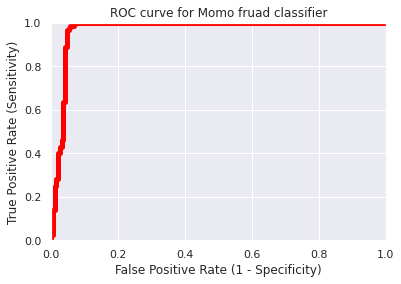

In [60]:
fpr,tpr,thresholds = roc_curve(y_val,lc_model.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [61]:
roc_auc_score(y_val, lc_model.predict_proba(x_val)[:,1])

0.9706438426162494

### Logistic Classifier k-fold Cross Validation and Grid Search

In [62]:
k_lc_model = LogisticRegression()

penalty = ['l1', 'l2']

C = np.logspace(0, 4, 10)

hyperparameters = dict(C=C, penalty=penalty)

gridPar = GridSearchCV(k_lc_model,hyperparameters, cv=5)

lc_cross_model = gridPar.fit(x_train, y_train)

predictions = lc_cross_model.predict(x_val)

logacc = metrics.accuracy_score( y_val,predictions)

/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWar

/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/selassie/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sel

In [63]:
logacc

0.9848484848484849

In [64]:
print(metrics.classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       190
           1       0.97      1.00      0.99       206

    accuracy                           0.98       396
   macro avg       0.99      0.98      0.98       396
weighted avg       0.99      0.98      0.98       396



In [65]:
print(confusion_matrix(y_val,predictions))

[[184   6]
 [  0 206]]


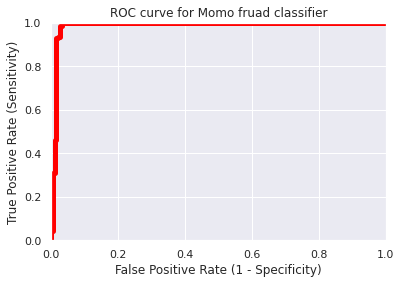

In [66]:
fpr,tpr,thresholds = roc_curve(y_val,lc_cross_model.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [67]:
roc_auc_score(y_val, lc_cross_model.predict_proba(x_val)[:,1])

0.9877363311190598

## Train the Random Forest Classifier

In [68]:
rf_model = RandomForestClassifier().fit(x_train, y_train)


In [69]:
predictions = rf_model.predict(x_val)


In [70]:
metrics.accuracy_score(y_val,predictions)

0.9949494949494949

In [71]:
print(metrics.classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       190
           1       1.00      1.00      1.00       206

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [72]:
print(confusion_matrix(y_val,predictions))

[[189   1]
 [  1 205]]


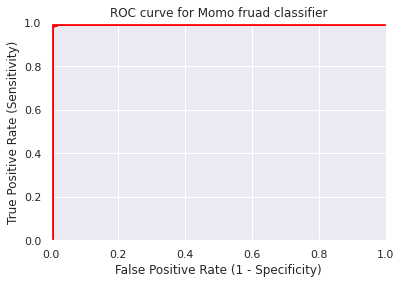

In [73]:
fpr,tpr,thresholds = roc_curve(y_val,rf_model.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [74]:
roc_auc_score(y_val, rf_model.predict_proba(x_val)[:,1])

0.9998978027593255

### Random Forest Classifier k-fold Cross Validation and Grid Search

In [75]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
k_rf_model = RandomForestClassifier()
gridPar = GridSearchCV(estimator = k_rf_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

rf_cross_models = gridPar.fit(x_train, y_train)

predictions = rf_cross_models.predict(x_val)

print(metrics.classification_report(y_val,predictions))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  5.8min finished


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       190
           1       1.00      1.00      1.00       206

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [76]:
metrics.accuracy_score(y_val,predictions )

0.9949494949494949

In [77]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       190
           1       1.00      1.00      1.00       206

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [78]:
print(confusion_matrix(y_val,predictions))

[[189   1]
 [  1 205]]


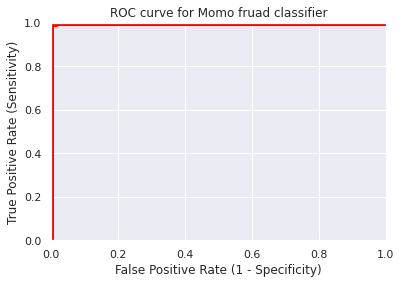

In [79]:
fpr,tpr,thresholds = roc_curve(y_val,rf_cross_models.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [80]:
roc_auc_score(y_val, rf_cross_models.predict_proba(x_val)[:,1])

0.9999233520694941

## Train the Support Vector Classifier

In [81]:
from sklearn.svm import SVC

sc_model = SVC(probability=True)

sc_model.fit(x_train,y_train)

SVC(probability=True)

In [82]:
predictions = sc_model.predict(x_val)

In [83]:
metrics.accuracy_score(y_val, predictions)

0.9747474747474747

In [84]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       190
           1       0.95      1.00      0.98       206

    accuracy                           0.97       396
   macro avg       0.98      0.97      0.97       396
weighted avg       0.98      0.97      0.97       396



In [85]:
print(confusion_matrix(y_val,predictions))

[[180  10]
 [  0 206]]


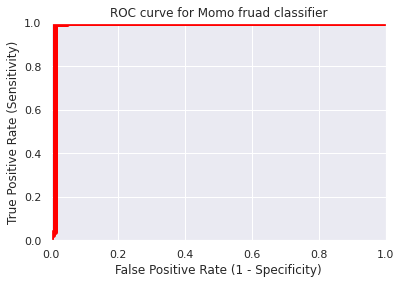

In [86]:
fpr,tpr,thresholds = roc_curve(y_val,sc_model.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [87]:
roc_auc_score(y_val, sc_model.predict_proba(x_val)[:,1])

0.989626980071538

### Support Vector Classifier k-fold Cross Support Vector Classifier 

In [88]:
from sklearn.model_selection import GridSearchCV
k_sc_model = SVC()
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf'],'probability':[True]} 
gridPar = GridSearchCV(k_sc_model,param_grid,refit=True,verbose=3)

sc_cross_model = gridPar.fit(x_train,y_train)

predictions = sc_cross_model.predict(x_val)

accuracy=accuracy_score(y_val,predictions)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf, probability=True ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, gamma=1, kernel=rbf, probability=True, score=0.857, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf, probability=True ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  C=0.1, gamma=1, kernel=rbf, probability=True, score=0.836, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf, probability=True ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  C=0.1, gamma=1, kernel=rbf, probability=True, score=0.853, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf, probability=True ....................
[CV]  C=0.1, gamma=1, kernel=rbf, probability=True, score=0.853, total=   0.2s
[CV] C=0.1, gamma=1, kernel=rbf, probability=True ....................
[CV]  C=0.1, gamma=1, kernel=rbf, probability=True, score=0.835, total=   0.2s
[CV] C=0.1, gamma=0.1, kernel=rbf, probability=True ..................
[CV]  C=0.1, gamma=0.1, kernel=rbf, probability=True, score=0.937, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf, probability=True ..................
[CV]  C=0.1, gamma=0.1, kernel=rbf, probability=True, score=0.929, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf, probability=True ..................
[CV]  C=0.1, gamma=0.1, kernel=rbf, probability=True, score=0.962, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf, probability=True ..................
[CV]  C=0.1, gamma=0.1, kernel=rbf, probability=True, score=0.937, total=   0.2s
[CV] C=0.1, g

[CV]  C=10, gamma=0.1, kernel=rbf, probability=True, score=0.983, total=   0.1s
[CV] C=10, gamma=0.1, kernel=rbf, probability=True ...................
[CV]  C=10, gamma=0.1, kernel=rbf, probability=True, score=0.992, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf, probability=True ..................
[CV]  C=10, gamma=0.01, kernel=rbf, probability=True, score=0.966, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf, probability=True ..................
[CV]  C=10, gamma=0.01, kernel=rbf, probability=True, score=0.945, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf, probability=True ..................
[CV]  C=10, gamma=0.01, kernel=rbf, probability=True, score=0.983, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf, probability=True ..................
[CV]  C=10, gamma=0.01, kernel=rbf, probability=True, score=0.954, total=   0.1s
[CV] C=10, gamma=0.01, kernel=rbf, probability=True ..................
[CV]  C=10, gamma=0.01, kernel=rbf, probability=True, score=0.962, total=   0.1s
[CV] C=10

[CV]  C=1000, gamma=0.01, kernel=rbf, probability=True, score=0.987, total=   0.1s
[CV] C=1000, gamma=0.01, kernel=rbf, probability=True ................
[CV]  C=1000, gamma=0.01, kernel=rbf, probability=True, score=0.987, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf, probability=True ...............
[CV]  C=1000, gamma=0.001, kernel=rbf, probability=True, score=0.966, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf, probability=True ...............
[CV]  C=1000, gamma=0.001, kernel=rbf, probability=True, score=0.958, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf, probability=True ...............
[CV]  C=1000, gamma=0.001, kernel=rbf, probability=True, score=0.996, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf, probability=True ...............
[CV]  C=1000, gamma=0.001, kernel=rbf, probability=True, score=0.979, total=   0.1s
[CV] C=1000, gamma=0.001, kernel=rbf, probability=True ...............
[CV]  C=1000, gamma=0.001, kernel=rbf, probability=True, score=0.970, to

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   16.4s finished


In [89]:
accuracy

0.9974747474747475

In [90]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       190
           1       1.00      1.00      1.00       206

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396



In [91]:
print(confusion_matrix(y_val,predictions))

[[190   0]
 [  1 205]]


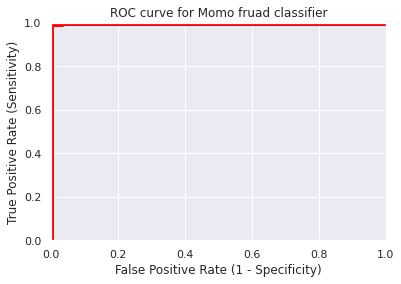

In [93]:
fpr,tpr,thresholds = roc_curve(y_val,sc_cross_model.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [94]:
roc_auc_score(y_val, sc_cross_model.predict_proba(x_val)[:,1])

0.9998467041389882

## Train the K-Nearest Neighbours

In [95]:
knn_model = KNeighborsClassifier(n_neighbors=7) 
knn_model.fit(x_train, y_train)
predictions = knn_model.predict(x_val)
metrics.accuracy_score(y_val, predictions)


0.9419191919191919

In [96]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       190
           1       0.90      1.00      0.95       206

    accuracy                           0.94       396
   macro avg       0.95      0.94      0.94       396
weighted avg       0.95      0.94      0.94       396



In [97]:
print(confusion_matrix(y_val,predictions))

[[167  23]
 [  0 206]]


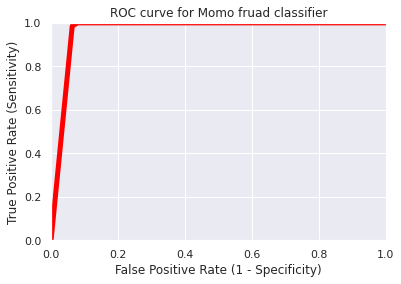

In [98]:
fpr,tpr,thresholds = roc_curve(y_val,knn_model.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [99]:
roc_auc_score(y_val, knn_model.predict_proba(x_val)[:,1])

0.9678461931527849

#### Feature Selection Using Recrsive Feature Elimination

### K-Nearest Neighbours k-fold Cross Validation and Grid Search

In [100]:
from sklearn.model_selection import GridSearchCV

k_knn_model = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1, 25)}

gridPar = GridSearchCV(k_knn_model, param_grid, cv=5)

knn_cross_model = gridPar.fit(x_train, y_train)

predictions = knn_cross_model.predict(x_val)
metrics.accuracy_score(y_val, predictions)

0.9671717171717171

In [101]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       190
           1       0.94      1.00      0.97       206

    accuracy                           0.97       396
   macro avg       0.97      0.97      0.97       396
weighted avg       0.97      0.97      0.97       396



In [102]:
print(confusion_matrix(y_val,predictions))

[[177  13]
 [  0 206]]


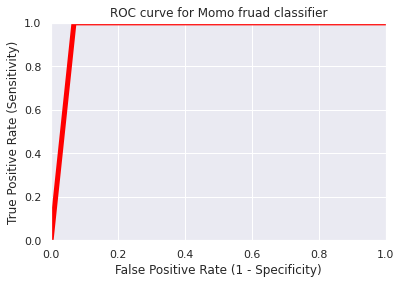

In [103]:
fpr,tpr,thresholds = roc_curve(y_val,knn_cross_model.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [104]:
roc_auc_score(y_val, knn_cross_model.predict_proba(x_val)[:,1])

0.9657894736842105

## Train the XGBoost Model

In [105]:
xbg_model = XGBClassifier()
xbg_model.fit(x_train, y_train)

y_predict = xbg_model.predict(x_val)
predictions = [round(value) for value in y_predict]

accurac = accuracy_score(y_val, predictions)
accurac

0.9949494949494949

In [106]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       190
           1       0.99      1.00      1.00       206

    accuracy                           0.99       396
   macro avg       1.00      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [107]:
print(confusion_matrix(y_val,predictions))

[[188   2]
 [  0 206]]


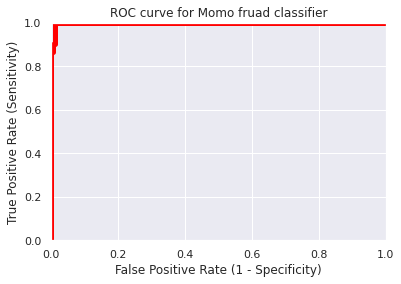

In [108]:
fpr,tpr,thresholds = roc_curve(y_val,xbg_model.predict_proba(x_val)[:,1],drop_intermediate=False)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Momo fruad classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.plot(fpr, tpr,color='red',lw=5)
plt.show()

In [109]:
roc_auc_score(y_val, xbg_model.predict_proba(x_val)[:,1])

0.9987736331119059

### XGBoost k-fold Cross Validation and Grid Search

In [110]:
k_xbg_model = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

gridPar = GridSearchCV(
    estimator = k_xbg_model,
    param_grid = parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

xgb_cross_model = gridPar.fit(x_train,y_train)

predictions = xgb_cross_model.predict(x_val)

accu=accuracy_score(y_val,predictions)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   10.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   39.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:  4.0min finished


In [111]:
accu

0.9924242424242424

In [112]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       190
           1       0.99      1.00      0.99       206

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [113]:
print(confusion_matrix(y_val,predictions))

[[187   3]
 [  0 206]]


### Plot the ROC for all models to find best model

In [114]:
r_probs = [0 for _ in range(len(y_val))]
lc_probs = lc_model.predict_proba(x_val)
lc_c_probs = lc_cross_model.predict_proba(x_val)
rf_probs = rf_model.predict_proba(x_val)
rf_c_probs = rf_cross_models.predict_proba(x_val)
sc_probs = sc_model.predict_proba(x_val)
sc_c_probs = sc_cross_model.predict_proba(x_val)
knn_probs = knn_model.predict_proba(x_val)
knn_c_probs = knn_cross_model.predict_proba(x_val)
xgb_probs = xbg_model.predict_proba(x_val)
xgb_c_probs = xgb_cross_model.predict_proba(x_val)

lc_probs = lc_probs[:, 1]
lc_c_probs = lc_c_probs[:, 1]
rf_probs = rf_probs[:, 1]
rf_c_probs = rf_c_probs[:, 1]
sc_probs = sc_probs[:, 1]
sc_c_probs = sc_c_probs[:, 1]
knn_probs = knn_probs[:, 1]
knn_c_probs = knn_c_probs[:, 1]
xgb_probs = xgb_probs[:, 1]
xgb_c_probs = xgb_c_probs[:, 1]

r_auc = roc_auc_score(y_val, r_probs)
lc_auc = roc_auc_score(y_val, lc_probs)
lc_c_auc = roc_auc_score(y_val, lc_c_probs)
rf_auc = roc_auc_score(y_val, rf_probs)
rf_c_auc= roc_auc_score(y_val, rf_c_probs)
sc_auc = roc_auc_score(y_val, sc_probs)
sc_c_auc = roc_auc_score(y_val, sc_c_probs)
knn_auc = roc_auc_score(y_val, knn_probs)
knn_c_auc = roc_auc_score(y_val, knn_c_probs)
xgb_auc = roc_auc_score(y_val, xgb_probs)
xgb_c_auc = roc_auc_score(y_val, xgb_c_probs)


### Calculate ROC curve
r_fpr, r_tpr, _ = roc_curve(y_val, r_probs)
lc_fpr, lc_tpr, _ = roc_curve(y_val, lc_probs)
lc_c_fpr, lc_c_tpr, _ = roc_curve(y_val, lc_c_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_probs)
rf_c_fpr, rf_c_tpr, _ = roc_curve(y_val, rf_c_probs)
sc_fpr, sc_tpr, _ = roc_curve(y_val, sc_probs)
sc_c_fpr, sc_c_tpr, _ = roc_curve(y_val, sc_c_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_val, knn_probs)
knn_c_fpr, knn_c_tpr, _ = roc_curve(y_val, knn_c_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_val, xgb_probs)
xgb_c_fpr, xgb_c_tpr, _ = roc_curve(y_val, xgb_c_probs)

### Print AUROC scores

In [115]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Linear Regression: AUROC = %.3f' % (lc_auc))
print('K-Fold Linear Regression: AUROC = %.3f' % (lc_c_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))
print('K-Fold Random Forest: AUROC = %.3f' % (rf_c_auc))
print('Support Vector: AUROC = %.3f' % (sc_auc))
print('K-Fold Support Vector: AUROC = %.3f' % (sc_c_auc))
print('K-Nearest Neighbor: AUROC = %.3f' % (knn_auc))
print('K-Fold K-Nearest Neighbor: AUROC = %.3f' % (knn_c_auc))
print('XGBoost: AUROC = %.3f' % (xgb_auc))
print('K-Fold XGBoost: AUROC = %.3f' % (xgb_c_auc))

Random (chance) Prediction: AUROC = 0.500
Linear Regression: AUROC = 0.971
K-Fold Linear Regression: AUROC = 0.988
Random Forest: AUROC = 1.000
K-Fold Random Forest: AUROC = 1.000
Support Vector: AUROC = 0.990
K-Fold Support Vector: AUROC = 1.000
K-Nearest Neighbor: AUROC = 0.968
K-Fold K-Nearest Neighbor: AUROC = 0.966
XGBoost: AUROC = 0.999
K-Fold XGBoost: AUROC = 0.998


### Plot the ROC curve

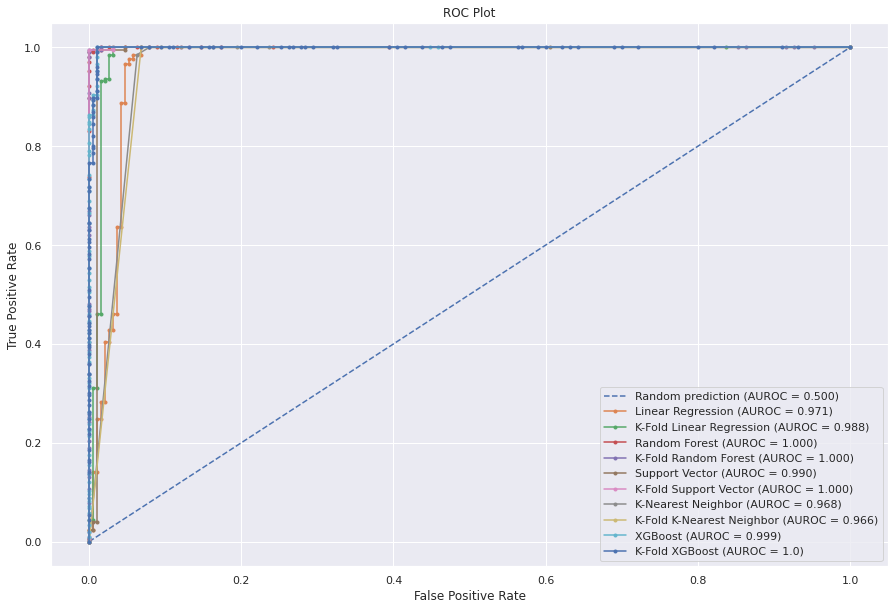

In [139]:
plt.figure(figsize=(15,10))

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(lc_fpr, lc_tpr, marker='.', label='Linear Regression (AUROC = %0.3f)' % lc_auc)
plt.plot(lc_c_fpr, lc_c_tpr, marker='.', label='K-Fold Linear Regression (AUROC = %0.3f)' % lc_c_auc)
plt.plot(rf_fpr, rf_tpr,  marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(rf_c_fpr, rf_c_tpr,  marker='.', label='K-Fold Random Forest (AUROC = %0.3f)' % rf_c_auc)
plt.plot(sc_fpr, sc_tpr, marker='.', label='Support Vector (AUROC = %0.3f)' % sc_auc)
plt.plot(sc_c_fpr, sc_c_tpr, marker='.', label='K-Fold Support Vector (AUROC = %0.3f)' % sc_c_auc)
plt.plot(knn_fpr, knn_tpr, marker='.', label='K-Nearest Neighbor (AUROC = %0.3f)' % knn_auc)
plt.plot(knn_c_fpr, knn_c_tpr, marker='.', label='K-Fold K-Nearest Neighbor (AUROC = %0.3f)' % knn_c_auc)
plt.plot(xgb_fpr, xgb_tpr,  marker='.', label='XGBoost (AUROC = %0.3f)' % xgb_auc)
plt.plot(xgb_c_fpr, xgb_c_tpr, marker='.', label='K-Fold XGBoost (AUROC = %0.1f)' % xgb_c_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

## Now we train the winning model on the remaining 20% test dataset

#### The Random Forest Model misclassified only 19 FP fraud cases as a result peformed better than the other models

### XGBoost Second Best Model

In [117]:
y_predict = xbg_model.predict(x_test)
predictions = [round(value) for value in y_predict]

accuracy_score(y_test, predictions)

print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       211
           1       0.99      1.00      0.99       186

    accuracy                           0.99       397
   macro avg       0.99      1.00      0.99       397
weighted avg       1.00      0.99      0.99       397

[[209   2]
 [  0 186]]


#### Peroforming a series of test on the XGBoost classier with dataset unknown to the model.

# TEST 1

In [119]:

fData = pd.read_excel ('testdataset5.xlsx')
fData.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,timeStamp,profileOrig,locationOrig,subscriberBehaviourOrig,simSwapOrig,networkDest,profileDest,locationDest,thresholdOrig
0,10,CASH_OUT,17139.99,C982265770,1769.94,0.0,C1933965693,4428218.48,4678941.51,0,0,"(datetime.datetime(2019, 5, 12, 7, 10, 41), 19...",Personal,Bono Region,PIN Reset,No,AIRTELTIGO,Organization,Volta Region,900000
1,10,CASH_OUT,2755.76,C1060059564,0.00,0.0,C258425622,254916.40,257672.16,0,0,"(datetime.datetime(2019, 5, 12, 8, 10, 41), 25...",Personal,Western North Region,PIN Reset,No,AIRTELTIGO,Personal,Western Region,900000
2,10,CASH_OUT,9097.72,C1605934616,0.00,0.0,C2120038041,2837396.74,2846494.45,0,0,"(datetime.datetime(2019, 5, 12, 9, 10, 41), 22...",Personal,Western North Region,Balance Check,No,AIRTELTIGO,Organization,Savannah Region,900000
3,10,CASH_OUT,142252.34,C473411746,0.00,0.0,C1202306289,3285243.13,3969861.01,0,0,"(datetime.datetime(2019, 5, 12, 10, 10, 41), 8...",Personal,Greater Accra Region,Balance Check,No,AIRTELTIGO,Organization,Volta Region,900000
4,10,CASH_OUT,156131.04,C1193098737,0.00,0.0,C294252921,3852127.70,4008258.73,0,0,"(datetime.datetime(2019, 5, 12, 11, 10, 41), 3...",Personal,North East Region,PIN Reset,No,VODAFONE,Organization,Volta Region,900000


In [120]:
label = LabelEncoder()
fData['type'] = label.fit_transform(fData['type'])
fData['nameOrig'] = label.fit_transform(fData['nameOrig'])
fData['nameDest']= label.fit_transform(fData['nameDest'])
fData['profileOrig']= label.fit_transform(fData['profileOrig']) 
fData['profileDest']= label.fit_transform(fData['profileDest']) 

fData['locationOrig'] = label.fit_transform(fData['locationOrig'])
fData['locationDest'] = label.fit_transform(fData['locationDest'])
fData['subscriberBehaviourOrig']= label.fit_transform(fData['subscriberBehaviourOrig'])
fData['simSwapOrig']= label.fit_transform(fData['simSwapOrig']) 
fData['networkDest']= label.fit_transform(fData['networkDest']) 

In [121]:
new_features = fData.drop(['step','newbalanceOrig','timeStamp','isFraud','thresholdOrig',
                       'newbalanceDest'],axis=1)
new_target = fData['isFraud']

In [122]:
sScaler = StandardScaler()
sScaler.fit(new_features)
new_features = sScaler.transform(new_features)

In [123]:
X_train,X_test,Y_train,Y_test = train_test_split(new_features, new_target,test_size=0.9, random_state = 100)

In [124]:
for datasets in (Y_train,Y_test):
    print(round(len(datasets) / len(new_features), 2))

0.1
0.9


In [125]:
print ('Input Data: {}'.format(new_features.shape))
print ('Output Data : {}'.format(new_target.shape))

Input Data: (10001, 14)
Output Data : (10001,)


In [127]:
y_predict = xbg_model.predict(X_test)
predictions = [round(value) for value in y_predict]

accuracy_score(Y_test, predictions)

0.8290189978891235

In [128]:
print(classification_report(Y_test,predictions))
print(confusion_matrix(Y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      8997
           1       0.00      0.25      0.00         4

    accuracy                           0.83      9001
   macro avg       0.50      0.54      0.45      9001
weighted avg       1.00      0.83      0.91      9001

[[7461 1536]
 [   3    1]]


# TEST 2